In [1]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
from joblib import Parallel, delayed
from scipy.optimize import minimize
import time
from mpl_toolkits.mplot3d import Axes3D
from scipy.linalg import block_diag, eig

In [2]:
# if you want static figures, dont run this
%matplotlib notebook

In [3]:
# used in combination as initial conditions to find cycles
shadow_states = np.array([-1, 0, 1])

# parameters
musqr = 5
s = 2 + musqr

n = 10

all_states = np.concatenate([coord.ravel().reshape(-1, 1) for coord in np.meshgrid(*(shadow_states for i in range(n)))], axis=1)

# Single cycle equation

In [4]:
def eqn(lattice_state):
    """
    lattice_state : np.ndarray
        Vector of field values at each lattice sit
    
    """
    # the equations of motion t+1 and t-1 terms are accomplished by the "roll" function = cyclic rotation
    cost_vector = (-1 * np.roll(lattice_state, -1) + (-1*(s-2)*lattice_state**3 +
                                               s*lattice_state) - np.roll(lattice_state, 1))
    # the l2 norm, giving us a scalar cost functional
    return cost_vector

def cost(lattice_state):
    return 0.5 * np.linalg.norm(eqn(lattice_state))**2

def jac(lattice_state):
    """
    Jacobian of the COST FUNCTION
    
    """
    F = eqn(lattice_state)
    JTF = -np.roll(F, 1) - np.roll(F, -1) + (-3 * (s - 2) * lattice_state**2 + s) * F  
    return JTF

def find_cycles(n):
    """
    Returns all cycles of length n; numerical tolerance is not checked for each instance. 
    """
    # this creates all cycle combinations to use as initial conditions.
    initial_conditions = list(itertools.product(*(shadow_states for i in range(n))))
    cycles = []
    # this runs the l-bfgs-b optimization algorithm for each initial condition
    with Parallel(n_jobs=-2) as parallel:
        cycles = parallel(delayed(minimize)(cost, phi, jac=jac, method='l-bfgs-b') for phi in initial_conditions)
    
    # scipy technically returns objects which describe the run time statistics; this simply returns
    # the final lattice states (may not be fully converged).
    
    # It returns them in an array of shape [N, 2]
    solutions = np.array([sol.x for sol in cycles])
    return solutions

In [5]:
def jacmatrix(lattice_state):
    """
    Returns a jacobian matrix
    """
    n = lattice_state.size
    J = (np.diag((-3*(s-2)*lattice_state**2 + s)) +
                 np.diag(-1*np.ones(n-1), k=1) +
                 np.diag(-1*np.ones(n-1), k=-1))
    J[0, -1] = -1
    J[-1, 0] = -1
    return J

# Completely tensorized cycle equations

The cycles are independent, and so we can store them in a $3^N$ by $N$ dimensional tensor (one row for each initial condition)
and then solve all at once by reshaping into a $N * 3^N$ dimensional vector.

The jacobian of this new abstraction would be a block diagonal matrix, each block corresponding to the jacobian matrix of each cycle. 

In [8]:
def cycle_eqn(cycle_state, n):
    """
    lattice_state : np.ndarray
        State variable
    
    """
    lattice_state = cycle_state.reshape(-1, n) 
    # the equations of motion
    eqn_tensor = (-1 * np.roll(lattice_state, -1, axis=1) + (-1*(s-2)*lattice_state**3 +
                                               s*lattice_state) - np.roll(lattice_state, 1, axis=1))
    # the l2 norm, giving us a scalar cost functional
    return eqn_tensor

def cycle_cost(cycle_state, n):
    return (0.5*np.linalg.norm(cycle_eqn(cycle_state, n), axis=1)**2).sum()

def cycle_jac(lattice_state, n):
    lattice_state = lattice_state.reshape(-1, n) 
    Ftensor = cycle_eqn(lattice_state, n)
    JTF = -np.roll(Ftensor, 1, axis=1) - np.roll(Ftensor, -1, axis=1) + (-3 * (s - 2) * lattice_state**2 + s) * Ftensor  
    return JTF.ravel()

def find_cycle_tensor(n):
    # if you want to tweak various scipy parameters; this makes it slightly more accurate 
    options = {}
#     options={'ftol': 1e-6, 'gtol': 1e-10, 'maxfun': 10000,
#                      'maxiter': 10000, 'disp': 1}
    all_lattice_states = np.concatenate([coord.ravel().reshape(-1, 1) for coord in np.meshgrid(*(shadow_states
                                                                                         for i in range(n)))], axis=1)
    cycles = minimize(cycle_cost, all_lattice_states, jac=cycle_jac, args=(n,), method='l-bfgs-b', options=options)
    cycle_tensor = cycles.x.reshape(-1, n)
    return cycle_tensor

def all_n_cycle_jacobians(all_n_cycles, n):
    J = np.zeros([3**n, n, n])
    # we are going to do some REALLY CONFUSING index manipulation. I highly recommend not spending too much time on 
    # understanding this. It's just to fill in the correct elements of the tensor with the single cycle jacobian values.
    upper_rows, upper_cols = kth_diag_indices(J[0], -1)
    lower_rows, lower_cols = kth_diag_indices(J[0], 1)
    zeroth = np.repeat(np.arange(3**n), len(upper_rows))
    upper_rows = np.tile(upper_rows, 3**n)
    upper_cols = np.tile(upper_cols, 3**n)
    lower_rows = np.tile(lower_rows, 3**n)
    lower_cols = np.tile(lower_cols, 3**n)

    J[zeroth, upper_rows, upper_cols] = -1
    J[zeroth, lower_rows, lower_cols] = -1
    J[:, 0, -1] = -1
    J[:, -1, 0] = -1
    tensor_diagonal = (-3*(s-2)*all_n_cycles**2 + s).ravel()

    rows, cols = np.diag_indices(n)
    zeroth = np.repeat(np.arange(3**n), len(rows))

    J[zeroth, np.tile(rows, 3**n), np.tile(cols, 3**n)] = tensor_diagonal
    return J

def kth_diag_indices(a, k):
    rows, cols = np.diag_indices_from(a)
    if k < 0:
        return rows[-k:], cols[:k]
    elif k > 0:
        return rows[:-k], cols[k:]
    else:
        return rows, cols
    
def n_cycle_everything(n):
    all_n_cycles = find_cycle_tensor(n)

    n_jacobians = all_n_cycle_jacobians(all_n_cycles, n)

    all_eig_val = []
    all_eig_vec = []
    for each_jac in n_jacobians:
        val, vec = eig(each_jac)
        all_eig_val.append(val)
        all_eig_vec.append(vec[np.newaxis])
    all_eig_val = np.concatenate(all_eig_val)
    all_eig_vec = np.concatenate(all_eig_vec)
    return all_n_cycles, all_eig_val, all_eig_vec, n_jacobians

In [9]:
n = 7
cycles, eigen_values, eigen_vectors, jacobians = n_cycle_everything(n)

In [ ]:
%%timeit
n = 7
cycles, eigen_values, eigen_vectors, jacobians = n_cycle_everything(n)

In [10]:
# if you wanted the block diagonal matrix of all n-cycle jacobians. Can very easily eat up all of your memory, use
# at your own risk
# val, vec = eig(block_diag(*tuple(n_jacobians)))

Eigenvalues only have real components; here they are plotted on the real line.

<IPython.core.display.Javascript object>


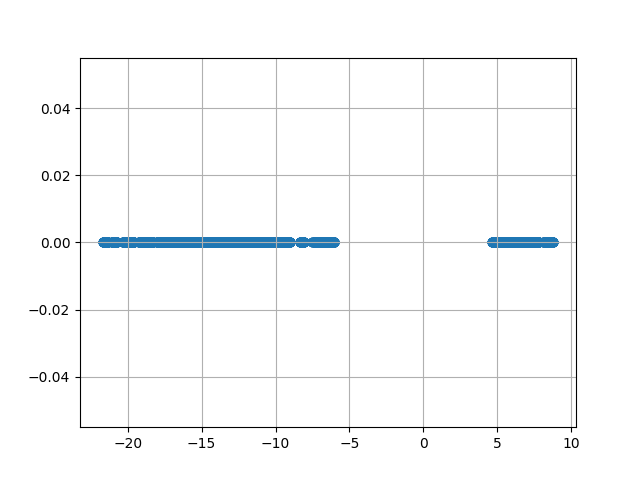

In [11]:
plt.figure()
plt.scatter(np.sort(eigen_values.real.ravel()), np.zeros(len(eigen_values)))
plt.grid()
plt.show()

As a line plot (think of this like a cumulative distribution function)

<IPython.core.display.Javascript object>


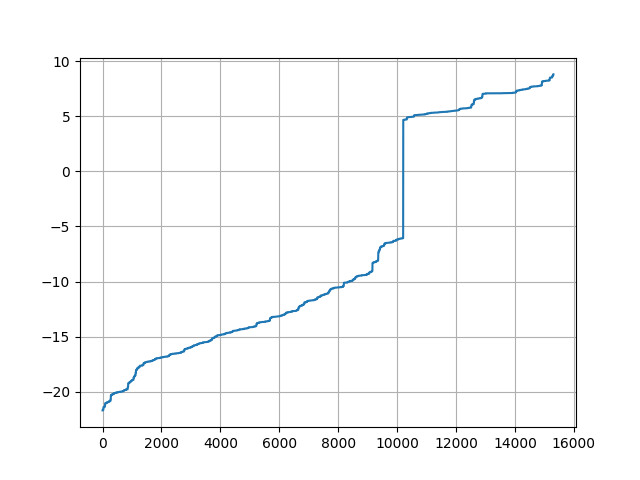

In [12]:
plt.figure()
plt.plot(np.sort(eigen_values.real.ravel()))
plt.grid()
plt.show()

As a histogram

<IPython.core.display.Javascript object>


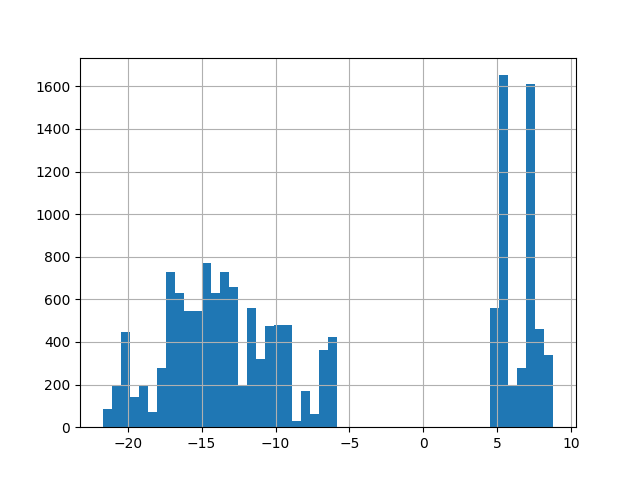

In [13]:
plt.figure()
plt.hist(eigen_values.real.ravel(), bins=50)
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


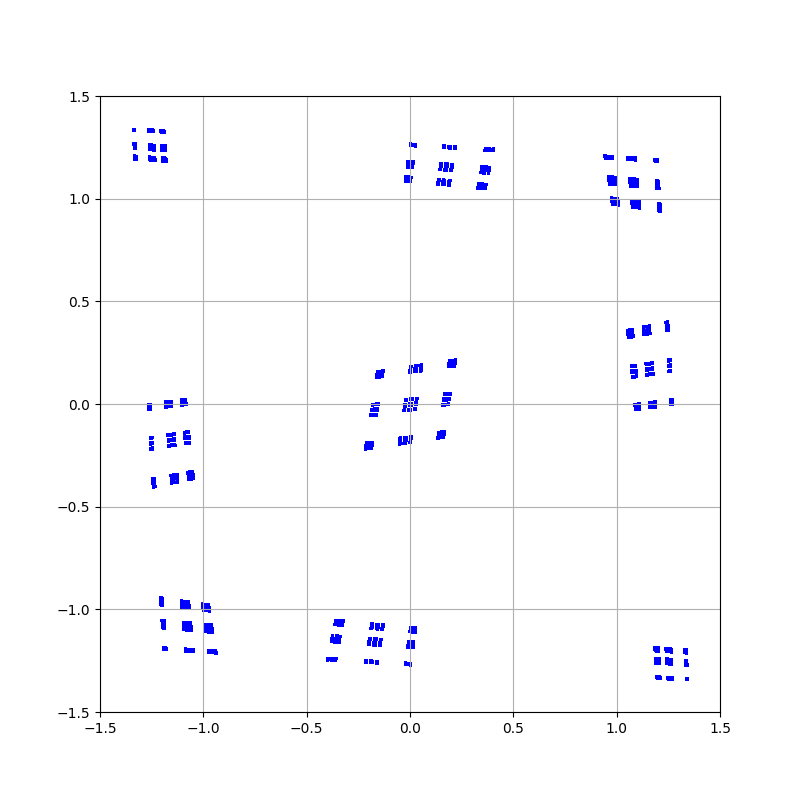

70.0684859752655


In [14]:
plt.figure(figsize=(8,8))
t0 = time.time_ns()/10**9
for i in range(2, 13):
    cycles = find_cycle_tensor(i)
    plt.scatter(cycles[:, 0], cycles[:, 1], color='b', alpha=0.5, s=0.5)
t1 = time.time_ns()/10**9
plt.xlim([-1.5, 1.5])
plt.ylim([-1.5, 1.5])
plt.grid()
plt.show()
print(t1-t0)

In [15]:
cycles = find_cycle_tensor(8)

<IPython.core.display.Javascript object>


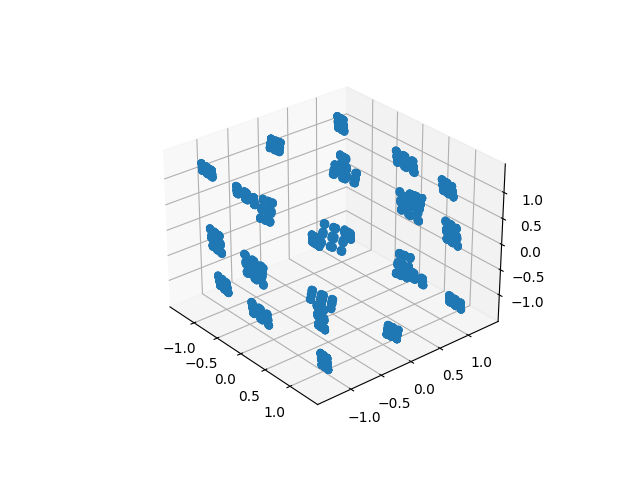

In [17]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(cycles[:, 0], cycles[:, 1], cycles[:, 2])
plt.show()